# Import Packages, Grab Data via Script

In [1]:
!pip install pybaseball
!pip install ipympl
%pip install unidecode
import unidecode
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.0/420.0 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 17.5 MB/s eta 0:00:00


In [2]:
%run plot_funcs.py
%run data.py
%matplotlib widget

from google.colab import output
output.enable_custom_widget_manager()

This is a large query, it may take a moment to complete


100%|██████████| 186/186 [05:43<00:00,  1.85s/it]


# Model Instantiation, Training on 2021 Data

In [3]:
# Define the column transformer for different scalers
minmax_features = ['game_week', 'launch_speed', 'angle']
standardscale_features = ['launch_angle', 'distance','sprint_speed']
categorical_features = ['home_team']

# Define preprocessor as ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scale', StandardScaler(), standardscale_features),           # Use StandardScaler for numeric features
        ('minmax', MinMaxScaler(), minmax_features),              # Use MinMaxScaler for numeric features
        ('categorical', OneHotEncoder(sparse=False), categorical_features)     # Use OneHotEncoder for categorical features
    ])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=69)

In [4]:
# Define RandomForest parameters
param_grid = {
    'n_estimators': [50,100,200],
    'criterion': ['gini','entropy'],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}

# Define Weighted Random Forest Model
model = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced')

# Define the metrics
metrics = {
    'Precision': precision_score,
    'Recall': recall_score,
    'F1-Score': f1_score,
    'ROC-AUC': roc_auc_score,
    "Cohen's Kappa": cohen_kappa_score,
    'Recall, double': None,
    'Recall, single': None,
    'Recall, triple': None
}

In [5]:
# Create an empty DataFrame to store the metrics
results_df = pd.DataFrame(columns=list(metrics.keys()))

classes = np.unique(y_train)


# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('random search', RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, scoring='roc_auc_ovr_weighted', cv=10, random_state=69))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)


# Calculate and store the metrics for the classifier
results = {key: None for key in metrics.keys()}


# Add all metrics to dictionary, add to DataFrame
for metric_name, metric_func in metrics.items():
  if metric_name in ['Precision', 'Recall', 'F1-Score']:
    metric_value = metric_func(y_test, y_pred, average='weighted')
  elif metric_name == 'ROC-AUC':
    metric_value = metric_func(y_test, y_pred_proba, average = 'weighted', multi_class = 'ovr')
  elif metric_name == "Cohen's Kappa":
    metric_value = metric_func(y_test, y_pred)

  results[metric_name] = metric_value

# Get classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract precision values from the report
class_names = list(report.keys())
class_names.remove('accuracy') # Remove 'accuracy' from class names
class_names.remove('macro avg') # Remove 'macro avg' from class names
class_names.remove('weighted avg') # Remove 'weighted avg' from class names

for class_name in class_names:
  results[f'Recall, {label_encoder.inverse_transform([int(class_name)])[0]}'] = report[class_name]['recall']


# Add the results to the DataFrame
results_df.loc['Final Model: Weighted RF'] = pd.Series(results)

In [6]:
# Print the results
results_df

,Precision,Recall,F1-Score,ROC-AUC,Cohen's Kappa,"Recall, double","Recall, single","Recall, triple"
Final Model: Weighted RF,0.897257,0.905545,0.897908,0.959692,0.74989,0.805383,0.960531,0.053892


# Predict On 2022 Players

In [77]:
# Get sprint speed data, change first and last name columns
speed_data = statcast_sprint_speed(2022, 1)
speed_data['last_name'] = speed_data.apply(lambda x: (unidecode.unidecode(x['last_name'])).lower(), axis = 1)
speed_data['first_name'] = speed_data.apply(lambda x: (unidecode.unidecode(x['first_name'][1:])).lower(), axis = 1)
speed_data['last_name'] = speed_data['last_name'].str.replace(' jr.', '')

# Get Fangraphs data, add first and last name columns, decode names
fg_data = pybaseball.batting_stats(2022, qual = 1)[['Name','AB','HR','ISO']]
fg_data['last_name'] = fg_data.apply(lambda x: str((unidecode.unidecode(x['Name'])).lower().split(' ')[1]), axis = 1)
fg_data['first_name'] = fg_data.apply(lambda x: str((unidecode.unidecode(x['Name'])).lower().split(' ')[0]), axis = 1)
fg_data = fg_data[['last_name','first_name','AB','HR','ISO']]

# Convert to strings
fg_data['last_name'] = fg_data['last_name'].astype(str)
fg_data['first_name'] = fg_data['first_name'].astype(str)
speed_data['last_name'] = speed_data['last_name'].astype(str)
speed_data['first_name'] = speed_data['first_name'].astype(str)

# Merge on first and last name of players
df = pd.merge(speed_data, fg_data, on=['last_name','first_name'], how='inner')[['last_name','first_name','AB','HR','ISO','sprint_speed']]
df.loc[(df['last_name'] == 'rodriguez') & (df['first_name'] == 'julio'), 'last_name'] = 'rodríguez'
df.loc[(df['last_name'] == 'azocar') & (df['first_name'] == 'jose'), 'first_name'] = 'josé'
df.loc[(df['last_name'] == 'pena') & (df['first_name'] == 'jeremy'), 'last_name'] = 'peña'
df.loc[(df['last_name'] == 'gimenez') & (df['first_name'] == 'andres'), 'first_name'] = 'andrés'
df.loc[(df['last_name'] == 'gimenez') & (df['first_name'] == 'andrés'), 'last_name'] = 'giménez'
df.loc[(df['last_name'] == 'gosselin') & (df['first_name'] == 'phil'), 'first_name'] = 'philip'
df.loc[(df['last_name'] == 'realmuto') & (df['first_name'] == 'j.t.'), 'first_name'] = 'j. t.'
df.loc[(df['last_name'] == 'hernandez') & (df['first_name'] == 'teoscar'), 'last_name'] = 'hernández'
df.loc[(df['last_name'] == 'hernandez') & (df['first_name'] == 'enrique'), 'last_name'] = 'hernández'
df.loc[(df['last_name'] == 'hernandez') & (df['first_name'] == 'yonny'), 'last_name'] = 'hernández'
df.loc[(df['last_name'] == 'hernandez') & (df['first_name'] == 'yadiel'), 'last_name'] = 'hernández'
df.loc[(df['last_name'] == 'hernandez') & (df['first_name'] == 'cesar'), 'last_name'] = 'hernández'
df.loc[(df['last_name'] == 'hernández') & (df['first_name'] == 'cesar'), 'first_name'] = 'césar'
df.loc[(df['last_name'] == 'munoz') & (df['first_name'] == 'yairo'),  'last_name'] = 'muñoz'
df.loc[(df['last_name'] == 'brujan') & (df['first_name'] == 'vidal'), 'last_name'] = 'bruján'
df.loc[(df['last_name'] == 'acuna') & (df['first_name'] == 'ronald'), 'last_name'] = 'acuña'
df.loc[(df['last_name'] == 'ramirez') & (df['first_name'] == 'jose'), 'first_name'] = 'josé'
df.loc[(df['last_name'] == 'abreu') & (df['first_name'] == 'jose'), 'first_name'] = 'josé'
df.loc[(df['last_name'] == 'godoy') & (df['first_name'] == 'jose'), 'first_name'] = 'josé'
df.loc[(df['last_name'] == 'ramirez') & (df['first_name'] == 'josé'), 'last_name'] = 'ramírez'
df.loc[(df['last_name'] == 'iglesias') & (df['first_name'] == 'jose'), 'first_name'] = 'josé'
df.loc[(df['last_name'] == 'mercado') & (df['first_name'] == 'oscar'), 'first_name'] = 'óscar'
df.loc[(df['last_name'] == 'garcia') & (df['first_name'] == 'avisail'), 'first_name'] = 'avisaíl'
df.loc[(df['last_name'] == 'garcia') & (df['first_name'] == 'avisaíl'), 'last_name'] = 'garcía'
df.loc[(df['last_name'] == 'dubon') & (df['first_name'] == 'mauricio'), 'last_name'] = 'dubón'
df.loc[(df['last_name'] == 'velazquez') & (df['first_name'] == 'nelson'), 'last_name'] = 'velázquez'
df.loc[(df['last_name'] == 'ramirez') & (df['first_name'] == 'harold'), 'last_name'] = 'ramírez'
df.loc[(df['last_name'] == 'gutierrez') & (df['first_name'] == 'kelvin'), 'last_name'] = 'gutiérrez'
df.loc[(df['last_name'] == 'gonzalez') & (df['first_name'] == 'erik'), 'last_name'] = 'gonzález'
df.loc[(df['last_name'] == 'baez') & (df['first_name'] == 'javier'), 'last_name'] = 'báez'
df.loc[(df['last_name'] == 'garcia') & (df['first_name'] == 'adolis'), 'last_name'] = 'garcía'
df.loc[(df['last_name'] == 'garcia') & (df['first_name'] == 'luis'), 'last_name'] = 'garcía'
df.loc[(df['last_name'] == 'nunez') & (df['first_name'] == 'dom'), 'last_name'] = 'nuñez'
df.loc[(df['last_name'] == 'encarnacion') & (df['first_name'] == 'jerar'), 'last_name'] = 'encarnación'
df.loc[(df['last_name'] == 'diaz') & (df['first_name'] == 'aledmys'), 'last_name'] = 'díaz'
df.loc[(df['last_name'] == 'diaz') & (df['first_name'] == 'yandy'), 'last_name'] = 'díaz'
df.loc[(df['last_name'] == 'diaz') & (df['first_name'] == 'elias'), 'last_name'] = 'díaz'
df.loc[(df['last_name'] == 'diaz') & (df['first_name'] == 'lewin'), 'last_name'] = 'díaz'
df.loc[(df['last_name'] == 'alcantara') & (df['first_name'] == 'sergio'), 'last_name'] = 'alcántara'
df.loc[(df['last_name'] == 'laureano') & (df['first_name'] == 'ramon'), 'first_name'] = 'ramón'
df.loc[(df['last_name'] == 'ibanez') & (df['first_name'] == 'andy'), 'last_name'] = 'ibáñez'
df.loc[(df['last_name'] == 'garcia') & (df['first_name'] == 'dermis'), 'first_name'] = 'dérmis'
df.loc[(df['last_name'] == 'mondesi') & (df['first_name'] == 'adalberto'), 'last_name'] = 'mondesí'
df.loc[(df['last_name'] == 'moncada') & (df['first_name'] == 'yoan'), 'first_name'] = 'yoán'
df.loc[(df['last_name'] == 'mejia') & (df['first_name'] == 'francisco'), 'last_name'] = 'mejía'
df.loc[(df['last_name'] == 'herrera') & (df['first_name'] == 'odubel'), 'first_name'] = 'odúbel'
df.loc[(df['last_name'] == 'crawford') & (df['first_name'] == 'j.p.'), 'first_name'] = 'j. p.'
df.loc[(df['last_name'] == 'pinto') & (df['first_name'] == 'rene'), 'first_name'] = 'rené'
df.loc[(df['last_name'] == 'urias') & (df['first_name'] == 'ramon'), 'last_name'] = 'urías'
df.loc[(df['last_name'] == 'urías') & (df['first_name'] == 'ramon'), 'first_name'] = 'ramón'
df.loc[(df['last_name'] == 'urias') & (df['first_name'] == 'luis'), 'last_name'] = 'urías'
df.loc[(df['last_name'] == 'matijevic') & (df['first_name'] == 'j.j.'), 'first_name'] = 'j. j.'
df.loc[(df['last_name'] == 'davis') & (df['first_name'] == 'j.d.'), 'first_name'] = 'j. d.'
df.loc[(df['last_name'] == 'martinez') & (df['first_name'] == 'j.d.'), 'first_name'] = 'j. d.'
df.loc[(df['last_name'] == 'higgins') & (df['first_name'] == 'p.j.'), 'first_name'] = 'p. j.'
df.loc[(df['last_name'] == 'cron') & (df['first_name'] == 'c.j.'), 'first_name'] = 'c. j.'
df.loc[(df['last_name'] == 'sano') & (df['first_name'] == 'miguel'), 'last_name'] = 'sanó'
df.loc[(df['last_name'] == 'sanchez') & (df['first_name'] == 'yolmer'), 'last_name'] = 'sánchez'
df.loc[(df['last_name'] == 'sanchez') & (df['first_name'] == 'gary'), 'last_name'] = 'sánchez'
df.loc[(df['last_name'] == 'sanchez') & (df['first_name'] == 'jesus'), 'last_name'] = 'sánchez'
df.loc[(df['last_name'] == 'sánchez') & (df['first_name'] == 'jesus'), 'first_name'] = 'jesús'
df.loc[(df['last_name'] == 'herrera') & (df['first_name'] == 'ivan'), 'first_name'] = 'iván'
df.loc[(df['last_name'] == 'mercedes') & (df['first_name'] == 'yermin'), 'first_name'] = 'yermín'
df.loc[(df['last_name'] == 'suarez') & (df['first_name'] == 'eugenio'), 'last_name'] = 'suárez'
df.loc[(df['last_name'] == 'perez') & (df['first_name'] == 'roberto'), 'last_name'] = 'pérez'
df.loc[(df['last_name'] == 'perez') & (df['first_name'] == 'carlos'), 'last_name'] = 'pérez'
df.loc[(df['last_name'] == 'jimenez') & (df['first_name'] == 'eloy'), 'last_name'] = 'jiménez'
df.loc[(df['last_name'] == 'gonzalez') & (df['first_name'] == 'luis'), 'last_name'] = 'gonzález'
df.loc[(df['last_name'] == 'arauz') & (df['first_name'] == 'jonathan'), 'last_name'] = 'araúz'
df.loc[(df['last_name'] == 'nido') & (df['first_name'] == 'tomas'), 'first_name'] = 'tomás'
df.loc[(df['last_name'] == 'machin') & (df['first_name'] == 'vimael'), 'last_name'] = 'machín'
df.loc[(df['last_name'] == 'vazquez') & (df['first_name'] == 'christian'), 'last_name'] = 'vázquez'
df.loc[(df['last_name'] == 'vogelbach') & (df['first_name'] == 'daniel'), 'first_name'] = 'dan'
df.loc[(df['last_name'] == 'pina') & (df['first_name'] == 'manny'), 'last_name'] = 'piña'
df.loc[(df['last_name'] == 'cano') & (df['first_name'] == 'robinson'), 'last_name'] = 'canó'
df.loc[(df['last_name'] == 'narvaez') & (df['first_name'] == 'omar'), 'last_name'] = 'narváez'
df.loc[(df['last_name'] == 'aguilar') & (df['first_name'] == 'jesus'), 'first_name'] = 'jesús'
df.loc[(df['last_name'] == 'maldonado') & (df['first_name'] == 'martin'), 'first_name'] = 'martín'
df.loc[(df['last_name'] == 'leon') & (df['first_name'] == 'sandy'), 'last_name'] = 'león'
df

,last_name,first_name,AB,HR,ISO,sprint_speed
0,carroll,corbin,104,4,0.240,30.7
1,thompson,bubba,170,1,0.047,30.4
2,witt,bobby,591,20,0.174,30.4
3,siri,jose,301,7,0.126,30.4
4,turner,trea,652,21,0.169,30.3
...,...,...,...,...,...,...
605,cabrera,miguel,397,5,0.063,23.1
606,pujols,albert,307,24,0.280,22.6
607,maldonado,martín,344,15,0.166,22.4
608,grandal,yasmani,327,5,0.067,22.0


## Visualize Model Error

In [33]:
# Define Dataframe for Model Error: true ISO Fangraphs values, average predicted ISO value by model
dev_df = pd.DataFrame(columns=['true_ISO','pp_ISO_avg'])

In [80]:
%run player_data.py

# Define number of times to run model
n_iterations = 1

# Iterating through entire dataframe of players
for i, j in df.iterrows():
  print(i, "Predicting On,", j['last_name'], j['first_name'])
  if (j['last_name'] == 'alvarez' and j['first_name'] == 'francisco') or (j['last_name'] == 'pérez' and j['first_name'] == 'carlos'):
    pass
  else:
    # Define dataframe for model's predictions
    plyr_df = pd.DataFrame(columns=['singles','doubles','triples','home_runs','pp_ISO'])

    # Define player variables
    plyr_AB = j['AB']
    plyr_HR = j['HR']
    plyr_ISO = j['ISO']
    plyr_speed = j['sprint_speed']

    # Acquire Statcast data for a player
    if (j['last_name'] == 'ramírez' and j['first_name'] == 'josé') or (j['last_name'] == 'allen' and j['first_name'] == 'nick') or (j['last_name'] == 'smith' and j['first_name'] == 'will') or (j['last_name'] == 'reynolds' and j['first_name'] == 'matt')or (j['last_name'] == 'duffy' and j['first_name'] == 'matt') or (j['last_name'] == 'murphy' and j['first_name'] == 'tom')or (j['last_name'] == 'bell' and j['first_name'] == 'josh')or (j['last_name'] == 'cruz' and j['first_name'] == 'nelson'):
      plyr_id = playerid_lookup(j['last_name'],j['first_name'])['key_mlbam'][1]
    else:
      plyr_id = playerid_lookup(j['last_name'],j['first_name'])['key_mlbam'][0]
    plyr_data = statcast_batter('2022-04-01', '2022-10-03', player_id = plyr_id)

    # Define list for multiple iterations of player data with their sprint speed sampled differently each time
    data_li = []
    for y in range(n_iterations):
      # Clean player data (X-values only), add to list
      X_pred = clean_plyr_data(plyr_data, plyr_speed)
      data_li.append(X_pred)

    # For each dataset, grab predictions by model on each
    for z in data_li:
      # Define metrics to save to dataframe
      model_res = {'singles': None, 'doubles': None, 'triples': None,'home_runs': plyr_HR, 'pp_ISO': None}

      # Predict on Weighted Forest, save metrics
      model_pred = pipeline.predict(z)
      model_res['singles'] = np.count_nonzero(model_pred == 1)
      model_res['doubles'] = np.count_nonzero(model_pred == 0)
      model_res['triples'] = np.count_nonzero(model_pred == 2)
      model_res['pp_ISO'] = round((model_res['doubles'] + 2*model_res['triples'] + 3*model_res['home_runs']) / plyr_AB, 3)

      # Add metrics to DataFrame
      plyr_df = plyr_df.append(model_res, ignore_index=True)

    # Save to Dataframe: true ISO from Fangraphs, Average predicted ISO by model
    dev_df_res = {'true_ISO': plyr_ISO, 'pp_ISO_avg': round(plyr_df['pp_ISO'].mean(), 3)}
    dev_df = dev_df.append(dev_df_res, ignore_index=True)

555 Predicting On, pérez carlos
556 Predicting On, sánchez gary
Gathering Player Data
557 Predicting On, trevino jose
Gathering Player Data
558 Predicting On, piscotty stephen
Gathering Player Data
559 Predicting On, quiroz esteban
Gathering Player Data
560 Predicting On, reks zach
Gathering Player Data
561 Predicting On, moustakas mike
Gathering Player Data
562 Predicting On, turner justin
Gathering Player Data
563 Predicting On, lowrie jed
Gathering Player Data
564 Predicting On, caratini victor
Gathering Player Data
565 Predicting On, wynns austin
Gathering Player Data
566 Predicting On, gallagher cam
Gathering Player Data
567 Predicting On, camargo johan
Gathering Player Data
568 Predicting On, casas triston
Gathering Player Data
569 Predicting On, romine austin
Gathering Player Data
570 Predicting On, pérez roberto
Gathering Player Data
571 Predicting On, plawecki kevin
Gathering Player Data
572 Predicting On, france ty
Gathering Player Data
573 Predicting On, voit luke
Gathering 

In [81]:
dev_df

,true_ISO,pp_ISO_avg
0,0.240,0.183
1,0.047,0.047
2,0.174,0.166
3,0.126,0.116
4,0.169,0.178
...,...,...
603,0.063,0.063
604,0.280,0.270
605,0.166,0.267
606,0.067,0.070


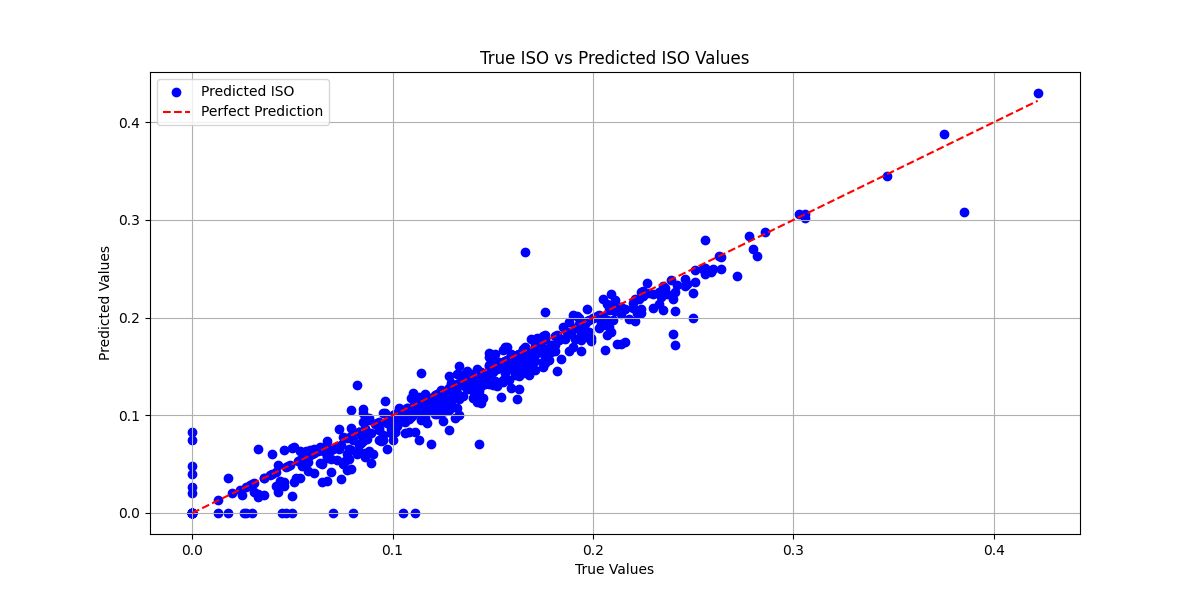

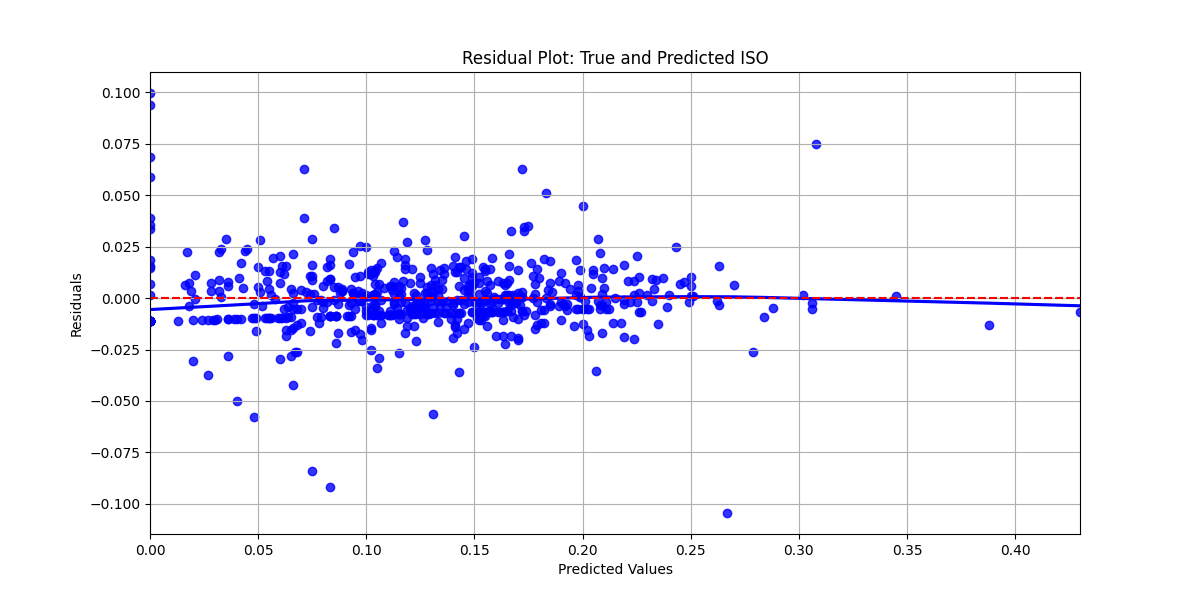

In [82]:
# Grab true and predicted values
true_values = dev_df['true_ISO']
predicted_values = dev_df['pp_ISO_avg']

# Calculate the residuals
residuals = true_values - predicted_values
# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(true_values, predicted_values, color='blue', label='Predicted ISO')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True ISO vs Predicted ISO Values')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot
plt.figure(figsize=(12, 6))
sns.residplot(x=predicted_values, y=residuals, lowess=True, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot: True and Predicted ISO')
plt.grid(True)
plt.show()

## Manipulate Sprint Speed, Predict new ISOs

In [86]:
# Define DataFrame for model metrics:
  # Deviation of manipulated sprint speed from true sprint speed
  # Average of Predicted ISO given manipulated sprint speed from Predicted ISO given TRUE sprint speed
dev_results_df = pd.DataFrame(columns=['Deviation_Speed','Deviation_pISO'])

In [93]:
# Define number of iterations
n_iterations = 1

# Iterate through Dataframe of players
for i, j in df.iloc[562:, :].iterrows():
  print(i, "Predicting for", j['last_name'], j['first_name'])
  if (j['last_name'] == 'alvarez' and j['first_name'] == 'francisco') or (j['last_name'] == 'pérez' and j['first_name'] == 'carlos'):
    pass
  else:
    # Define variables from player's Fangraphs/Statcast Data
    speed_vars = np.arange(j['sprint_speed'] - 2, j['sprint_speed'] + 2, 0.1)
    plyr_AB = j['AB']
    plyr_HR = j['HR']
    plyr_ISO = j['ISO']
    plyr_speed = j['sprint_speed']

    # Acquire Statcast data for a player
    if (j['last_name'] == 'ramírez' and j['first_name'] == 'josé') or (j['last_name'] == 'allen' and j['first_name'] == 'nick') or (j['last_name'] == 'smith' and j['first_name'] == 'will') or (j['last_name'] == 'reynolds' and j['first_name'] == 'matt')or (j['last_name'] == 'duffy' and j['first_name'] == 'matt') or (j['last_name'] == 'murphy' and j['first_name'] == 'tom')or (j['last_name'] == 'bell' and j['first_name'] == 'josh')or (j['last_name'] == 'cruz' and j['first_name'] == 'nelson'):
      plyr_id = playerid_lookup(j['last_name'],j['first_name'])['key_mlbam'][1]
    else:
      plyr_id = playerid_lookup(j['last_name'],j['first_name'])['key_mlbam'][0]
    plyr_data = statcast_batter('2022-04-01', '2022-10-03', player_id = plyr_id)

    # Get the predicted ISO given a player's actual sprint speed first to compare to manipulated values of sprint speed
    # On plot, point for this pair of speed and
    baseline_data = []
    baseline_pred_ISOs = []
    for a in range(n_iterations):
      # Clean player data and add to list
      X_pred = clean_plyr_data(plyr_data, plyr_speed)
      baseline_data.append(X_pred)

    #Make predictions for each dataset in list
    for b in baseline_data:
      # Predict on Model
      model_pred = pipeline.predict(z)

      # Calculate ISO given actual sprint speed
      pred_doubles = np.count_nonzero(model_pred == 0)
      pred_triples = np.count_nonzero(model_pred == 2)
      pred_ISO = round((pred_doubles + 2*pred_triples + 3*plyr_HR) / plyr_AB, 3)

      baseline_pred_ISOs.append(pred_ISO)

    # Take average of predicted ISOs given player's actual Statcast sprint speed
    # Should act as (0,0) on deviation plot
    baseline_pISO = round(sum(baseline_pred_ISOs) / len(baseline_pred_ISOs), 3)

    # Iterating through all possible values for sprint speed
    for x in speed_vars:
      # Define Metrics for each dataframe of results given a different sprint speed
      plyr_df = pd.DataFrame(columns=['Deviation_Speed','Deviation_pISO'])

      # Loop through each iteration with new dataset, append to list
      data_li = []
      for y in range(n_iterations):
        X_pred = clean_plyr_data(plyr_data, x)
        data_li.append(X_pred)

      # Make predictions and save deviations of each predicted ISO value from true ISO value
      for z in data_li:
        # Define metrics to save to dataframe
        model_res = {'Deviation_Speed': round(x - plyr_speed, 1), 'Deviation_pISO': None}

        # Predict on Weighted Forest, save metrics
        model_pred = pipeline.predict(z)
        pred_singles = np.count_nonzero(model_pred == 1)
        pred_doubles = np.count_nonzero(model_pred == 0)
        pred_triples = np.count_nonzero(model_pred == 2)
        model_res['pISO'] = round((pred_doubles + 2*pred_triples + 3*plyr_HR) / plyr_AB, 3)
        plyr_df = plyr_df.append(model_res, ignore_index=True)

      # take average of deviations in predictions
      speed_deviation = round(plyr_df['Deviation_Speed'].mean(),1)

      avg_pISO_deviation = round(plyr_df['pISO'].mean() - baseline_pISO, 3)

      # Save results to dataframe
      dev_results = {'Deviation_Speed': speed_deviation, 'Deviation_pISO': avg_pISO_deviation}

      # Dataframe includes deviation of speed from Statcast sprint speed, and average deviation of predicted ISO given manipulated sprint speed from the average predicted ISO given true sprint speed
      # 20 predictions per player, for each manipulated sprint speed value
      dev_results_df = dev_results_df.append(dev_results, ignore_index = True)

562 Predicting for turner justin
Gathering Player Data
563 Predicting for lowrie jed
Gathering Player Data
564 Predicting for caratini victor
Gathering Player Data
565 Predicting for wynns austin
Gathering Player Data
566 Predicting for gallagher cam
Gathering Player Data
567 Predicting for camargo johan
Gathering Player Data
568 Predicting for casas triston
Gathering Player Data
569 Predicting for romine austin
Gathering Player Data
570 Predicting for pérez roberto
Gathering Player Data
571 Predicting for plawecki kevin
Gathering Player Data
572 Predicting for france ty
Gathering Player Data
573 Predicting for voit luke
Gathering Player Data
574 Predicting for beer seth
Gathering Player Data
575 Predicting for díaz lewin
Gathering Player Data
576 Predicting for papierski michael
Gathering Player Data
577 Predicting for casali curt
Gathering Player Data
578 Predicting for nuñez dom
Gathering Player Data
579 Predicting for hedges austin
Gathering Player Data
580 Predicting for stanton g

In [ ]:
dev_results_df

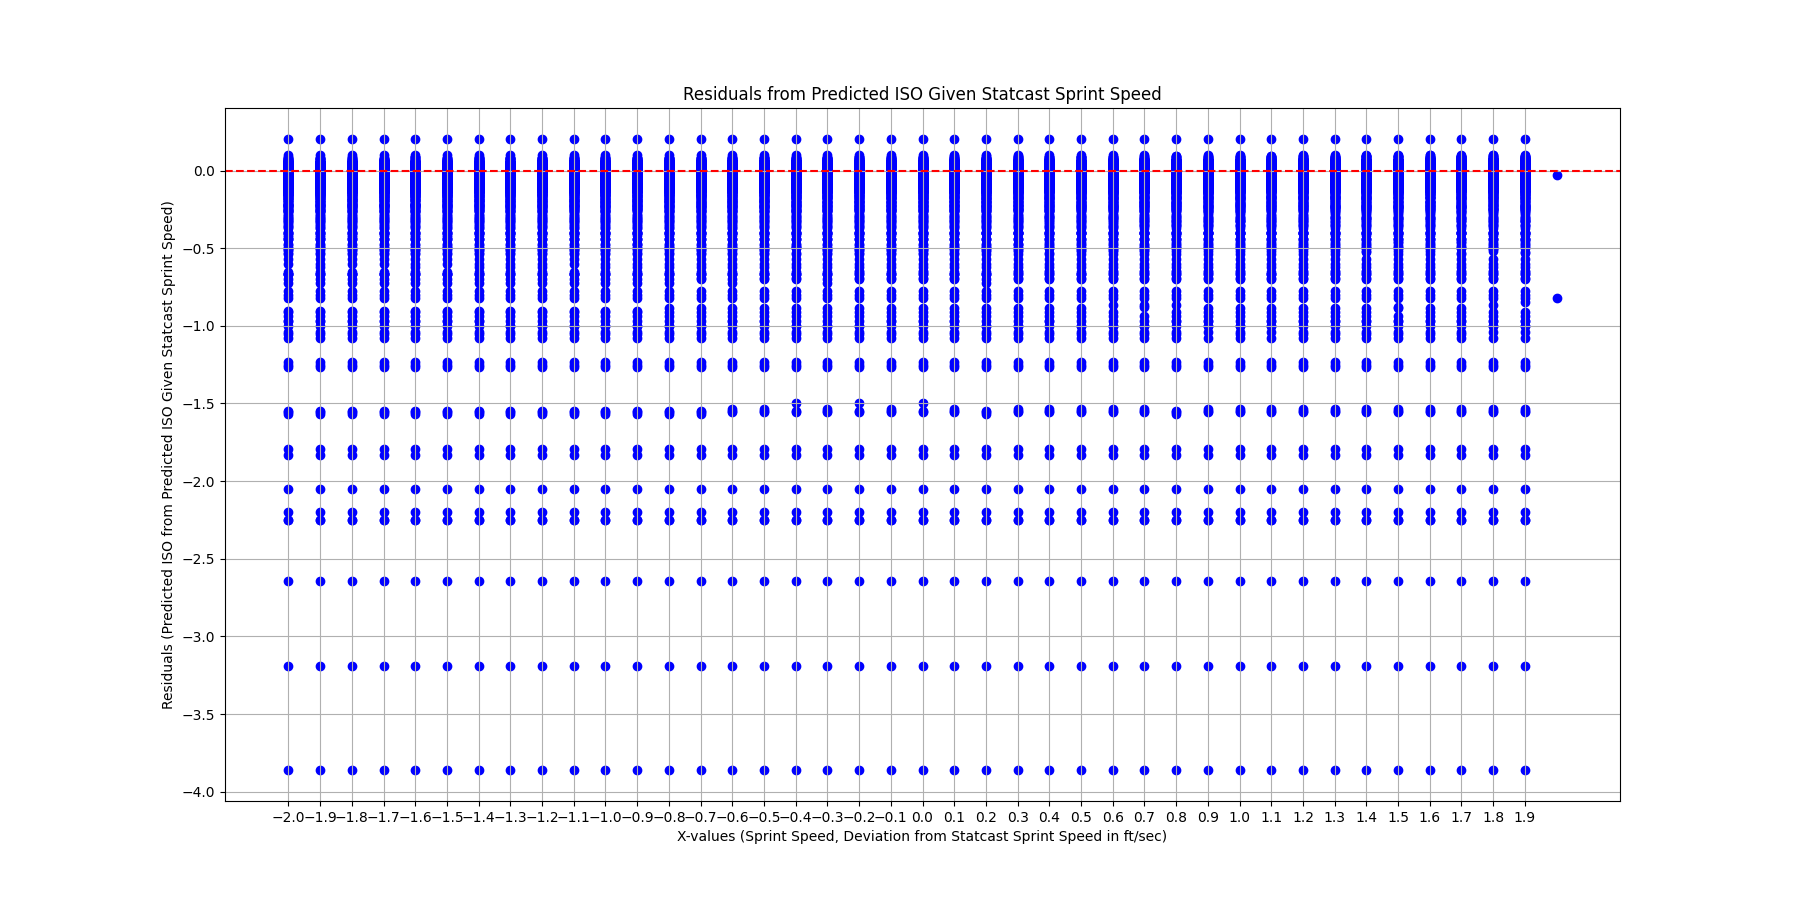

In [95]:
# Define the x-values
x_values = dev_results_df['Deviation_Speed']

# Calculate the y-values as residuals from 0
y_values = dev_results_df['Deviation_pISO']

plt.figure(figsize = (18, 9))
# Plot the residuals
plt.scatter(x_values, y_values, color='blue')
# Set the x-axis ticks
plt.xticks(np.arange(-2,2,0.1))
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('X-values (Sprint Speed, Deviation from Statcast Sprint Speed in ft/sec)')
plt.ylabel('Residuals (Predicted ISO from Predicted ISO Given Statcast Sprint Speed)')
plt.title('Residuals from Predicted ISO Given Statcast Sprint Speed')
plt.grid(True)
plt.show()